# Проект: вариант 1

Для выполнения проекта необходимо:

- Выгрузить и изучить имеющиеся данные.
- Понять как устроены данные и как они связаны между собой.
- Принять решения о трактовке спорных моментов в данных. 
- Исследовать данные на наличие аномалий.
- Выполнить следующие задачи:
    1. Написать функцию для подсчета retention.
    2. Определить на основе A/B тестирования наборов акционных предложений, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
    3. Предложить
    метрики для оценки результатов последнего прошедшего тематического события в игре.
- Описать причины решений и расчетов.

Импорт необходимых библиотек:

In [1]:
import pandas as pd
import requests
import scipy.stats as ss
from scipy.stats import chi2_contingency
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlencode
%matplotlib inline

# Считывание данных

In [45]:
path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-ta-markova/shared/problem1-reg_data.csv'

df_task_1_reg = pd.read_csv(path_to_file, sep=';')

df_task_1_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [46]:
path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-ta-markova/shared/problem1-auth_data.csv'

df_task_1_auth = pd.read_csv(path_to_file, sep=';')

df_task_1_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Функция для считывания датафрейма с Яндекс диска:

In [6]:
def convert_from_yandex_disk_to_df(path_to_file: str) -> pd.DataFrame:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=path_to_file))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return pd.read_csv(download_url, sep=';')

In [7]:
df_task_2_url = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 

df_task_2 = convert_from_yandex_disk_to_df(df_task_2_url)

df_task_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


# Задание 1

### Датафрейм df_task_1_reg 
Датафрейм содержит информацию данные о времени входа пользователей в игру.

- **reg_ts** — дата регистрация пользователя

- **uid** — идентификационный код пользователя

#### Общий анализ

In [8]:
df_task_1_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [9]:
df_task_1_reg.shape

(1000000, 2)

In [10]:
df_task_1_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [11]:
df_task_1_reg.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [12]:
df_task_1_reg[['reg_ts', 'uid']].min()

reg_ts    911382223
uid               1
dtype: int64

In [13]:
df_task_1_reg[['reg_ts', 'uid']].max()

reg_ts    1600874244
uid          1110622
dtype: int64

In [14]:
df_task_1_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

#### Вывод:

- Датафрейм **df_task_1_reg** считан корректно. 
- Типы значений столбцов соответствуют действительности, однако в столбце reg_ts необходимо преобразовать unix-время в дату.

### Датафрейм df_task_1_auth 
Датафрейм содержит информацию данные о времени входа пользователей в игру.

- **auth_ts** — дата посещения игры пользователем
- **uid** — идентификационный код пользователя

#### Общий анализ

In [15]:
df_task_1_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [16]:
df_task_1_auth.shape

(9601013, 2)

In [17]:
df_task_1_auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [18]:
df_task_1_auth.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [19]:
df_task_1_auth[['auth_ts', 'uid']].min()

auth_ts    911382223
uid                1
dtype: int64

In [20]:
df_task_1_auth[['auth_ts', 'uid']].max()

auth_ts    1600874244
uid           1110622
dtype: int64

In [21]:
df_task_1_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

#### Вывод:

- Датафрейм **df_task_1_auth** считан корректно. 
- Типы значений столбцов соответствуют действительности, однако в столбце auth_ts необходимо преобразовать unix-время в дату.

### Общий вывод по датафреймам df_task_1_auth и df_task_1_reg: 

Оба датафрейма имеют одинаковые максимальные и минимальные значения по столбцам **reg_ts** и **auth_ts** и столбцам **uid**, что предполагает:
1. Исходя из значений столбцов **reg_ts** и **auth_ts**, максимальная и минимальные даты совпадают, т.е. в обоих датафреймах рассматривается одинаковый промежуток времени.
2. Первым пользователем, зарегистрировавшимся в игре, будет считаться пользователь под номером 1, второй — 2 и т.д.
    
Число уникальных пользователей в обоих датафреймах — **1000000**, при этом максимальный идентификационный номер пользователя — **1110622**, что предполагает отсутствие информации о **110622** пользователей:
1. Возможно, ошибка в данных.
2. Возможно, информация отсутствует, поскольку пользователи зарегистрировались в игре, но позднее удалили свой аккаунт. 



### Анализ и предобработка объединенных датафреймов df_task_1_reg и df_task_1_auth

Преобразуем unix-время в дату в датафрейме reg_data:

In [22]:
reg_data = df_task_1_reg

reg_data['reg_ts'] = pd.to_datetime(df_task_1_reg['reg_ts'], unit='s').dt.date

reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


Узнаем максимальное и минимальное значение дат в датафрейме reg_data:

In [23]:
reg_data[['reg_ts']].min()

reg_ts    1998-11-18
dtype: object

In [24]:
reg_data[['reg_ts']].max()

reg_ts    2020-09-23
dtype: object

Преобразуем unix-время в дату в датафрейме auth_data:

In [25]:
auth_data = df_task_1_auth

auth_data['auth_ts'] = pd.to_datetime(df_task_1_auth['auth_ts'], unit='s').dt.date

auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


Узнаем максимальное и минимальное значение дат в датафрейме auth_data:

In [26]:
auth_data[['auth_ts']].min()

auth_ts    1998-11-18
dtype: object

In [27]:
auth_data[['auth_ts']].max()

auth_ts    2020-09-23
dtype: object

**Вывод:** исходя из того,  максимальная и минимальные даты совпадают в обоих датафреймах, ранее сделанный вывод об одинаковых промежутках времени подтвержден. 

Объедим датафреймы auth_data и reg_data:

In [28]:
join_df = auth_data.merge(reg_data, how='left', on='uid')

join_df.head()

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22


In [29]:
join_df.shape

(9601013, 3)

In [30]:
join_df.dtypes

auth_ts    object
uid         int64
reg_ts     object
dtype: object

In [31]:
join_df.nunique()

auth_ts       6169
uid        1000000
reg_ts        5110
dtype: int64

In [32]:
join_df.isna().sum()

auth_ts    0
uid        0
reg_ts     0
dtype: int64

Переименуем название колонок в датафрейме join_df, где reg_date будет означать дату регистрации, а auth_date — дату посещения игры пользователем:

In [33]:
join_df = join_df.rename(columns={'reg_ts': 'reg_date', 'auth_ts': 'auth_date'})

join_df.head()

,auth_date,uid,reg_date
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22


Мы будем рассчитывать retention пользователей по дням от даты регистрации, поэтому необходимо создать новую колонку quantity_day, где вычислим количество дней между датой регистрацией пользователя и датой посещения им игры:

In [34]:
join_df['quantity_day'] = (join_df.auth_date - join_df.reg_date).dt.days

join_df.head()

,auth_date,uid,reg_date,quantity_day
0,1998-11-18,1,1998-11-18,0
1,1999-07-22,2,1999-07-22,0
2,1999-07-25,2,1999-07-22,3
3,1999-07-31,2,1999-07-22,9
4,1999-08-05,2,1999-07-22,14


Для расчета retention пользователей по дням от даты регистрации необходимо вычислить показатель удержаний пользователей на определенном временном интервале. Для этого необходимо выбрать начальную и конечную дату регистрации пользователей и количество дней, прошедших с начала регистрации.

Выберем в качестве начальной и конечной даты регистрации пользователей начало и конец некоторого месяца в некотором году, поскольку для расчета retention пользователей по дням от даты регистрации в рамках игрового приложения имеет смысл рассчитать показатель удержания в течение месяца:

In [35]:
start_date = '2020-01-01'
finish_date = '2020-01-31'

Выберем количество дней, прошедших с начала регистрации пользователей, в данном случае также возьмем значение равное количеству дней в соответствующем месяце, в нашем случае январю:

In [36]:
days = 31

join_df = join_df[join_df.quantity_day <= days]

Определим необходимый временной промежуток:

In [37]:
join_df = join_df[pd.to_datetime(join_df['reg_date']).between(pd.to_datetime(start_date), 
                                                              pd.to_datetime(finish_date))]
    
join_df.head()

,auth_date,uid,reg_date,quantity_day
6183545,2020-01-01,716362,2020-01-01,0
6183553,2020-01-01,716364,2020-01-01,0
6183560,2020-01-01,716365,2020-01-01,0
6183566,2020-01-01,716366,2020-01-01,0
6183574,2020-01-01,716367,2020-01-01,0


In [38]:
join_df.reg_date.max()

datetime.date(2020, 1, 31)

In [39]:
join_df.reg_date.min()

datetime.date(2020, 1, 1)

Группируем пользователей в когорты:

In [40]:
join_df = join_df.groupby(['reg_date', 'quantity_day']).agg({'uid': 'nunique'}).reset_index() 

join_df.head()    

,reg_date,quantity_day,uid
0,2020-01-01,0,1061
1,2020-01-01,1,28
2,2020-01-01,2,48
3,2020-01-01,3,36
4,2020-01-01,4,60


Подсчитываем retention пользователей по дням от даты регистрации:

In [41]:
join_df = join_df.pivot_table(values='uid', index='reg_date', columns='quantity_day').fillna(0)

retention_rate = join_df.divide(join_df[0], axis=0).mul(100).round(1)

Построим тепловую таблицу и зададим название таблицы и осей:

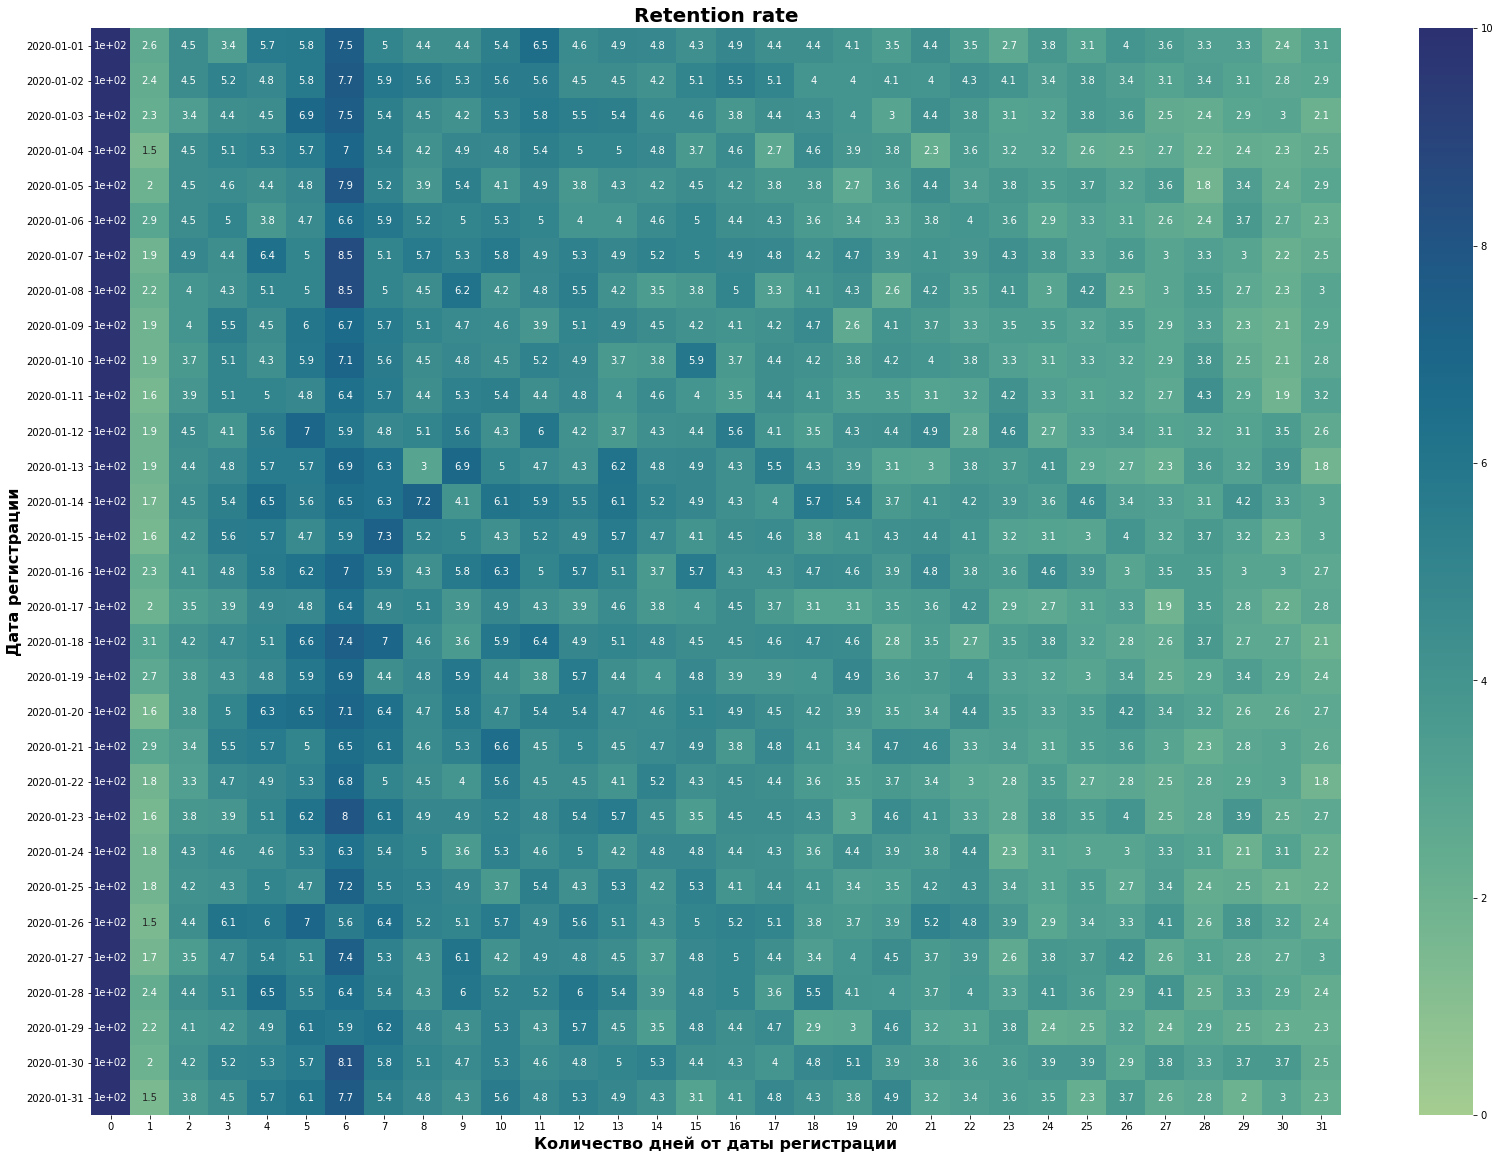

In [42]:
plt.figure(figsize=(28, 20))
sns.heatmap(retention_rate, vmin=0, vmax=10, cmap='crest', annot=True)    
plt.title('Retention rate', fontweight='bold', fontsize=20)
plt.xlabel('Количество дней от даты регистрации', fontweight='bold', fontsize=16)
plt.ylabel('Дата регистрации', fontweight='bold', fontsize=16)
plt.yticks(rotation=0)
plt.show()

### Ответ на поставленный вопрос:

Retention – один из самых важных показателей в компании. Ваша задача написать функцию, которая будет считать **retention** игроков (по дням от даты регистрации игрока).

Напишем функцию, которая позволит нам рассчитать Retention по дням от даты регистрации игроков:

In [43]:
def retention_rate(df1, df2, start_date, finish_date, days):
    
    # преобразуем unix-время в дату:
    df1['reg_ts'] = pd.to_datetime(df1['reg_ts'], unit='s').dt.date
    df2['auth_ts'] = pd.to_datetime(df2['auth_ts'], unit='s').dt.date
    
    # объединим датафреймы и переименуем колонки:
    join_df = df2.merge(df1, how='left', on='uid')
    join_df = join_df.rename(columns={'reg_ts': 'reg_date', 'auth_ts': 'auth_date'})
    
    # вычислим количество дней между датой регистрацией пользователя и датой посещения им игры:
    join_df['quantity_day'] = (join_df.auth_date - join_df.reg_date).dt.days
    join_df = join_df[join_df.quantity_day <= days]
    
    # определим необходимый временной промежуток:
    join_df = join_df[pd.to_datetime(join_df['reg_date']).between(pd.to_datetime(start_date), 
                                                                  pd.to_datetime(finish_date))]
    
    # группируем пользователей в когорты:
    join_df = join_df.groupby(['reg_date', 'quantity_day']).agg({'uid': 'nunique'}).reset_index() 
    
    # подсчитываем retention пользователей по дням от даты регистрации:
    join_df = join_df.pivot_table(values='uid', index='reg_date', columns='quantity_day').fillna(0)
    retention_rate = join_df.divide(join_df[0], axis=0).mul(100).round(1)
    
    # построим тепловую таблицу и зададим название таблицы и осей:
    plt.figure(figsize=(28, 20))
    retention_rate = sns.heatmap(retention_rate, vmin=0, vmax=10, cmap='crest', annot=True)    
    plt.title('Retention rate', fontweight='bold', fontsize=20)
    plt.xlabel('Количество дней от даты регистрации', fontweight='bold', fontsize=16)
    plt.ylabel('Дата регистрации', fontweight='bold', fontsize=16)
    plt.yticks(rotation=0)
    plt.show()
    
    return retention_rate

Протестируем работу функции:

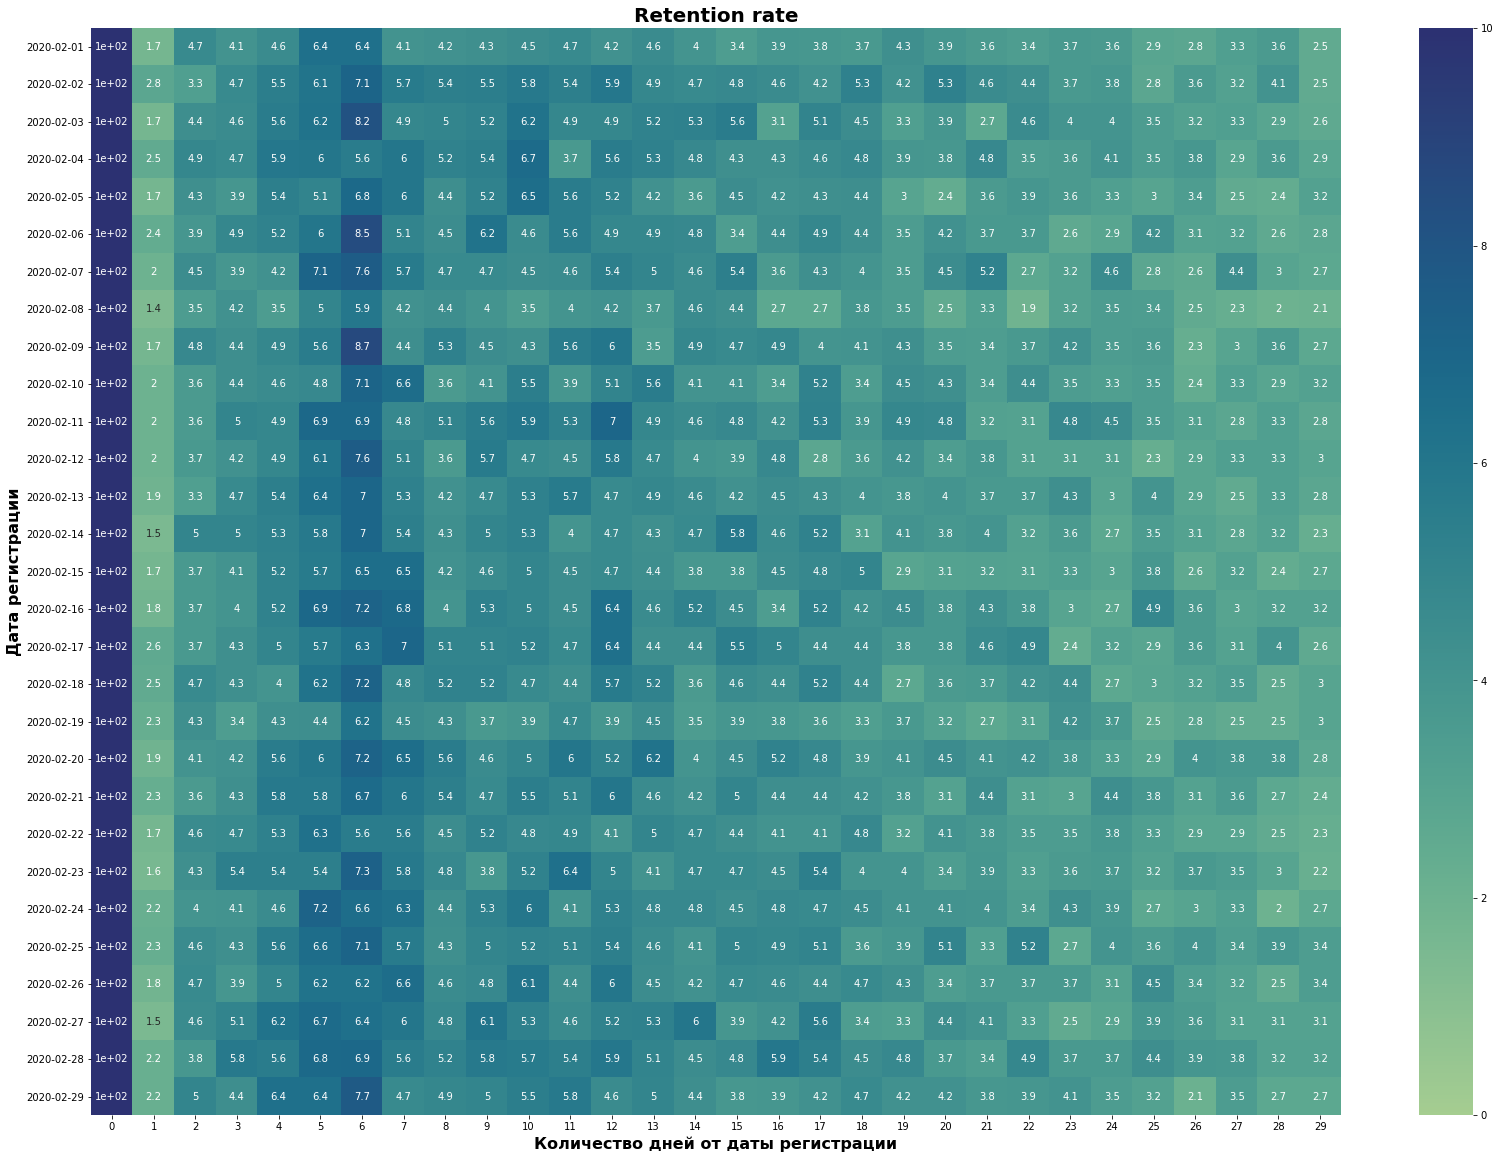

In [47]:
retention_rate(df_task_1_reg, df_task_1_auth, '2020-02-01', '2020-02-29', 29)

# Задание 2

### Датафрейм df_task_2 
Датафрейм содержит результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений

- **user_id** — идентификационный код пользователя
- **revenue** — доход от пользователя
- **testgroup** — тестовая и контрольная группы



#### Общий анализ

In [48]:
df_task_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [49]:
df_task_2.shape

(404770, 3)

In [50]:
df_task_2.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [51]:
df_task_2.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [52]:
df_task_2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Выведем описательную статистику о группе а:

In [53]:
df_task_2.loc[df_task_2['testgroup'] == "a"].revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

**Вывод:** согласно условию задачи в контрольной группе 202103 пользователя, значит группа **а** контрольная.

Выведем описательную статистику о группе b:

In [54]:
df_task_2.loc[df_task_2['testgroup'] == "b"].revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

**Вывод:** согласно условию задачи в тестовой группе 202667 пользователя, значит группа **b** тестовая.

#### Вывод:

- Датафрейм **df_task_2** считан корректно. 
- Типы значений столбцов соответствуют действительности, изменять типы не требуется. 
- Максимальное revenue в контрольной группе значительно выше, чем в тестовой группе.
- Средне-квадратичноe отклонение (std) в контрольной группе значительно выше, чем в тестовой группе.

### Анализ и предобработка датафрейма df_task_2

Для удобства дальнейшего анализа разделим датафрейм df_task_2 на два датафрейма c информацией о контрольной и тестовой группах:

In [55]:
control_df = df_task_2.loc[df_task_2['testgroup'] == "a"]

control_df.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [56]:
test_df = df_task_2.loc[df_task_2['testgroup'] == "b"]

test_df.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


Посмотрим на распределение доходов для каждой группы на графике:

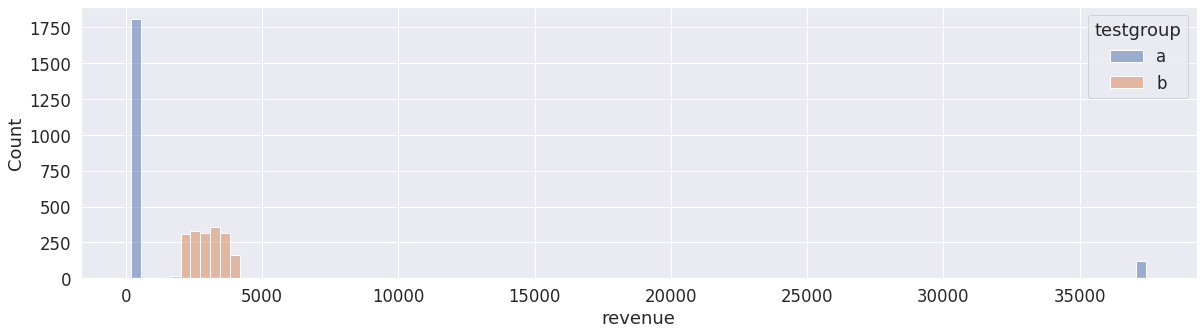

In [57]:
plt.figure(figsize=(20, 5))
sns.set(font_scale=1.5)
sns.histplot(x='revenue', data=df_task_2.loc[df_task_2['revenue'] > 0], hue='testgroup')

**Вывод**: доход в тестовой группе **b** распределен более равномерно, нежели в контрольной **а**, где часть пользователей приносят менее 5000 у.е., а часть пользователей — более 35000 у.е.

Выведем описательную статистику о платящих пользователях в контрольной группе **а**:

In [58]:
control_df.loc[control_df['revenue'] > 0].revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

**Вывод**:

1. До 25 % платящих пользователей из контрольной группы потратили 257 и менее у.е.
2. От 25 % до 50 % платящих пользователей из контрольной группы потратили 258-311 у.е. 
3. От 50 % до 75 % платящих пользователей из контрольной группы потратили 312-361 у.е. 
4. От 75 % платящих пользователей из контрольной группы потратили 362 и более у.е. 

Выведем описательную статистику о платящих пользователях в тестовой группе **b**:

In [59]:
test_df.loc[test_df['revenue'] > 0].revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

**Вывод**:

1. До 25 % платящих пользователей из тестовой группы потратили 2513 и менее у.е.
2. От 25 % до 50 % платящих пользователей из тестовой группы потратили 2514-3022 у.е. 
3. От 50 % до 75 % платящих пользователей из тестовой группы потратили 3023-3478 у.е. 
4. От 75 % платящих пользователей из тестовой группы потратили 3479 и более у.е.

Рассмотрим более подробно датафрейм с контрольной группой, где было выявлено неравномерное распределение данных о доходах.

Выведем описательную статистику о пользователях, приносящих доход выше 35000 у.е.:

In [60]:
control_df.loc[control_df['revenue'] > 35000].revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

**Вывод:** всего пользователей 123, разброс дохода от них составляет от 37293 до 37433 у.е.

Выведем описательную статистику о пользователях, приносящих доход ниже 5000 у.е.:

In [61]:
control_df.loc[control_df['revenue'] < 5000].loc[control_df['revenue'] > 0].revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

**Вывод:** всего пользователей 1805, разброс дохода от них составляет от 200 до 400 у.е.

Посчитаем, какой процент от платящих пользователей составляют те, кто приносит доход выше 35000 у.е.:

In [62]:
round((123 / 1928) * 100, 1)

6.4

Посчитаем, какую долю в доходе приносят пользователи, платящие выше 35000 у.е.:

In [63]:
round((control_df.loc[control_df['revenue'] > 5000].revenue.sum() / control_df.revenue.sum()) * 100, 1)

89.4

**Вывод**: 
1. Наибольшую долю в доходе в контрольной группе приносят пользователи, платящие выше 35000 у.е., — это 89.4% против 10.63% 
2. Наибольшую долю в количестве пользователей в контрольной группе составляют пользователи, платящие ниже 5000 у.е., — это 93.4% против 6.4% 
3. Можно заключить, что в контрольной группе два сегмента пользователей, один из которых можно охарактеризовать как самые лояльные пользователи.

Проверим, являются ли верными вводные данные из условия задачи, что ARPU в тестовой группе **b** выше на 5%, чем в контрольной **a**.

Рассчитаем ARPU для контрольной группы:

In [64]:
ARPU_control = round((control_df['revenue'].sum() / control_df['user_id'].count()), 2)

ARPU_control

25.41

Рассчитаем ARPU для тестовой группы:

In [65]:
ARPU_test = round((test_df['revenue'].sum() / test_df['user_id'].count()), 2)

ARPU_test

26.75

Рассчитаем разницу в ARPU:

In [66]:
round(100 - ((ARPU_control / ARPU_test) * 100))

5

**Вывод:** вводные данные верны.

### Выбор метрик

Поскольку из имеющихся данных для статистических тестов мы можем использовать только информацию о доходах (размер дохода с пользователя, количество платящих и неплатящих пользователей), то анализировать будем следующие метрики:
1. Конверсию, где целевым действием будем считать любой платеж пользователя, — Conversion Rate
2. Средний доход на привлеченного пользователя — ARPU
3. Средний доход на платящего пользователя — ARPPU

### Расчет метрик

Создадим датафрейм, где будет представлена информация о количестве клиентов, доходе, количестве платящих клиентов, ARPU, ARPPU и Conversion Rate по каждой группе.

Посчитаем количество пользователей и доход:

In [67]:
info_df = df_task_2.groupby('testgroup', as_index=False) \
    .agg({'user_id': 'nunique', 'revenue': 'sum'}) \
    .rename(columns={'user_id': 'user'})

info_df

,testgroup,user,revenue
0,a,202103,5136189
1,b,202667,5421603


Посчитаем количество платящих пользователей и объединим с датафреймом info_df:

In [68]:
# посчитаем количество платящих пользователей
info_df_1 = df_task_2.loc[df_task_2['revenue'] > 0] \
    .groupby('testgroup', as_index=False) \
    .agg({'user_id': 'nunique'}) \
    .rename(columns={'user_id': 'paying_user'})

# объединим датафреймы
info_df = info_df.merge(info_df_1, how='left', on='testgroup')

info_df

,testgroup,user,revenue,paying_user
0,a,202103,5136189,1928
1,b,202667,5421603,1805


Посчитаем ARPU, ARPPU и Conversion Rate:

In [69]:
info_df['ARPU'] = round((info_df['revenue'] / info_df['user']), 2)
info_df['ARPPU'] = round((info_df['revenue'] / info_df['paying_user']), 2)
info_df['CR'] = round((info_df['paying_user'] / info_df['user']) * 100, 2)

info_df

,testgroup,user,revenue,paying_user,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.41,2664.00,0.95
1,b,202667,5421603,1805,26.75,3003.66,0.89


**Вывод:** 
1. Показатели ARPU, ARPPU, дохода в контрольной группе ниже, чем в тестовой.
2. Показатель CR в контрольной группе выше, чем в тестовой.

### Сonversion rate

#### Выбор статистического теста и проведение статистического анализа

Поскольку для расчета conversion rate используем категориальные переменные: пользователи платят / не платят, используем для статического теста хи-квадрат:

- $H_0$: различия в конверсии в тестовой и контрольной группе нет
- $H_1$: различия в конверсии в тестовой и контрольной группе есть

Для построения таблицы сопряженности добавим в датафрейме df_task_2 колонку paying, где 0 — не платящий пользователь, 1 — платящий пользователь:

In [70]:
df_task_2['paying'] = df_task_2.revenue.apply(lambda x: '0' if x == 0 else '1').astype('int')

Построим таблицу сопряженности:

In [71]:
number_paying_group = pd.crosstab(df_task_2.testgroup, df_task_2.paying)

number_paying_group

paying,0,1
testgroup,,
a,200175,1928
b,200862,1805


Применим статистический тест:

In [72]:
stat, p, dof, expected = chi2_contingency(number_paying_group)

stat, p

(4.374729521260405, 0.03647561892312613)

In [73]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


**Вывод**: 
1. В результате статистического теста мы установили, что изменение значимо, и отклонили гипотезу $H_0$.
2. Соответственно, различия в конверсии в тестовой и контрольной группе есть.
3. Можно заключить, что новый набор акционных предложений статзначимо сократил количество платящих пользователей приложения.

#### Выбор статистического теста и проведение статистического анализа без учета лояльных пользователей в контрольной группе

Сформулируем гипотезы:

- $H_0$: различия в конверсии в тестовой и контрольной группе нет
- $H_1$: различия в конверсии в тестовой и контрольной группе есть

Построим таблицу сопряженности:

In [74]:
number_paying_group = pd.crosstab(df_task_2.loc[df_task_2['revenue'] <= 35000].testgroup, 
                                  df_task_2.loc[df_task_2['revenue'] <= 35000].paying)

number_paying_group

paying,0,1
testgroup,,
a,200175,1805
b,200862,1805


Применим статистический тест:

In [75]:
stat, p, dof, expected = chi2_contingency(number_paying_group)

stat, p

(0.0073526946879701, 0.9316668591658103)

In [76]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


**Вывод**:

1. В результате статистического теста мы установили, что изменение незначимо, и не отклонили гипотезу $H_0$.
2. Соответственно, различия в конверсии в тестовой и контрольной группе нет.
3. Можно заключить, что новый набор акционных предложений статзначимо не сократил количество платящих пользователей приложения.

### ARPU

#### Выбор статистического теста и проведение статистического анализа

Поскольку речь идет о количественных переменных: средний доход на привлеченного пользователя, можно использовать статический тест t-тест при условии, что:
- выполняется требование гомогенности дисперсий
- выполняется требование о нормальности распределения (если размер выборки меньше 30)

В нашем случае нас интересует выполнение первого требования, поскольку размер выборки больше 30. Проверим гомогенность дисперсий с помощью критерия Левена:

- $H_0$: дисперсии в тестовой и контрольной группе гомогенны
- $H_1$: дисперсии в тестовой и контрольной группе не гомогенны

Применим статистический тест:

In [77]:
stat, p = ss.levene(control_df.revenue, test_df.revenue)

stat, p

(0.3896289474701388, 0.5324948591043842)

In [78]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


**Вывод**:

1. В результате статистического теста мы не отклонили гипотезу $H_0$.
2. Соответственно, дисперсии в тестовой и контрольной группе гомогенны.
3. Можно заключить, что мы можем использовать t-test.

Сформулируем гипотезы и проведем статистический тест:

- $H_0$: различия в ARPU в тестовой и контрольной группе нет
- $H_1$: различия в ARPU в тестовой и контрольной группе есть

Применим статистический тест:

In [79]:
stat, p = ss.ttest_ind(control_df.revenue, test_df.revenue)

stat, p

(-0.6242026493616787, 0.532494858971837)

In [80]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


**Вывод**:

1. В результате статистического теста мы установили, что изменение незначимо, и не отклонили гипотезу $H_0$.
2. Соответственно, различия в ARPU в тестовой и контрольной группе нет.
3. Можно заключить, что новый набор акционных предложений статзначимо не изменил средний доход на привлеченного пользователя.

#### Выбор статистического теста и проведение статистического анализа без учета лояльных пользователей в контрольной группе

Проверим, можно ли использовать t-test в качестве статистического теста:

- $H_0$: дисперсии в тестовой и контрольной группе гомогенны
- $H_1$: дисперсии в тестовой и контрольной группе не гомогенны

In [81]:
stat, p = ss.levene(control_df.loc[control_df['revenue'] <= 35000].revenue, test_df.revenue) 

stat, p

(1400.7231388579885, 4.912187546515184e-306)

In [82]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


**Вывод**:

1. В результате статистического теста мы отклонили гипотезу $H_0$.
2. Соответственно, дисперсии в тестовой и контрольной группе не гомогенны.
3. Можно заключить, что мы не можем использовать t-test.

Поскольку дисперсии в тестовой и контрольной группе не гомогенны, следует использовать критерий Геймса-Хоувелла:

- $H_0$: различия в ARPU в тестовой и контрольной группе нет
- $H_1$: различия в ARPU в тестовой и контрольной группе есть

Применим статистический тест:

In [83]:
pg.pairwise_gameshowell(data=df_task_2.loc[df_task_2['revenue'] <= 35000], dv="revenue", between="testgroup") 

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,a,b,2.702926,26.751287,-24.048361,0.641485,-37.488549,206804.655821,0.001,-0.117866


**Вывод**:

1. В результате статистического теста мы установили, что p-value < 0.05, т.е. изменение значимо, и отклонили гипотезу $H_0$.
2. Соответственно, различия в ARPU в тестовой и контрольной группе есть.
3. Можно заключить, что новый набор акционных предложений статзначимо изменил средний доход на привлеченного пользователя.

### ARPPU

#### Выбор статистического теста и проведение статистического анализа

Поскольку речь идет о количественных переменных: средний доход на платящего пользователя, можно использовать статический тест t-тест при условии, что:
- выполняется требование гомогенности дисперсий
- выполняется требование о нормальности распределения (если размер выборки меньше 30)

В нашем случае нас интересует выполнение первого требования, поскольку размер выборки больше 30. Проверим гомогенность дисперсий с помощью критерия Левена:

- $H_0$: дисперсии в тестовой и контрольной группе гомогенны
- $H_1$: дисперсии в тестовой и контрольной группе не гомогенны

In [84]:
stat, p = ss.levene(control_df.loc[control_df['revenue'] > 0].revenue, test_df.loc[test_df['revenue'] > 0].revenue)

stat, p

(80.85567421779912, 3.779689868667878e-19)

In [85]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


**Вывод**:

1. В результате статистического теста мы отклонили гипотезу $H_0$.
2. Соответственно, дисперсии в тестовой и контрольной группе не гомогенны.
3. Можно заключить, что мы не можем использовать t-test.

Поскольку дисперсии в тестовой и контрольной группе не гомогенны, следует использовать критерий Геймса-Хоувелла:

- $H_0$: различия в ARPPU в тестовой и контрольной группе нет
- $H_1$: различия в ARPPU в тестовой и контрольной группе есть

Применим статистический тест:

In [86]:
pg.pairwise_gameshowell(data=df_task_2.loc[df_task_2['revenue'] > 0], dv="revenue", between="testgroup") 

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,a,b,2663.998444,3003.658172,-339.659728,206.526497,-1.64463,1943.481522,0.100208,-0.053854


**Вывод**:

1. В результате статистического теста мы установили, что p-value > 0.05, т.е. изменение незначимо, и не отклонили гипотезу $H_0$.
2. Соответственно, различия в ARPPU в тестовой и контрольной группе нет.
3. Можно заключить, что новый набор акционных предложений статзначимо не изменил средний доход на платящего пользователя.

#### Выбор статистического теста и проведение статистического анализа без учета лояльных пользователей в контрольной группе

Проверим, можно ли использовать t-test в качестве статистического теста:

- $H_0$: дисперсии в тестовой и контрольной группе гомогенны
- $H_1$: дисперсии в тестовой и контрольной группе не гомогенны

In [87]:
stat, p = ss.levene(control_df.loc[(control_df['revenue'] > 0) & (control_df['revenue'] <= 35000)].revenue, 
                    test_df.loc[test_df['revenue'] > 0].revenue)

stat, p

(4256.810323520863, 0.0)

In [88]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


**Вывод**:

1. В результате статистического теста мы отклонили гипотезу $H_0$.
2. Соответственно, дисперсии в тестовой и контрольной группе не гомогенны.
3. Можно заключить, что мы не можем использовать t-test.

Поскольку дисперсии в тестовой и контрольной группе не гомогенны, следует использовать критерий Геймса-Хоувелла:

- $H_0$: различия в ARPPU в тестовой и контрольной группе нет
- $H_1$: различия в ARPPU в тестовой и контрольной группе есть

Применим статистический тест:

In [89]:
pg.pairwise_gameshowell(data=df_task_2.loc[(df_task_2['revenue'] > 0) & (df_task_2['revenue'] <= 35000)], 
                        dv="revenue", between="testgroup")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,a,b,302.458172,3003.658172,-2701.2,13.546828,-199.397225,1840.9028,0.001,-6.635982


**Вывод**:

1. В результате статистического теста мы установили, что p-value < 0.05, т.е. изменение значимо, и отклонили гипотезу $H_0$.
2. Соответственно, различия в ARPPU в тестовой и контрольной группе есть.
3. Можно заключить, что новый набор акционных предложений статзначимо изменил средний доход на привлеченного пользователя.

### Общий вывод:

1. Показатели ARPU, ARPPU, дохода в контрольной группе ниже, чем в тестовой.
2. Показатель CR в контрольной группе выше, чем в тестовой.
2. В контрольной группе два сегмента пользователей: пользователи, приносящие доход менее 5000 у.е., и пользователи, приносящие доход более 35000 у.е. Последних можно охарактеризовать как самых лояльных клиентов.
4. Если мы учитываем лояльных клиентов в контрольной группе **а** при проведении статистических тестов, то получим следующие результаты: 
    - В результате статистического теста мы установили, новый набор акционных предложений статзначимо сократил количество платящих пользователей приложения.
    - В результате статистического теста мы установили, что новый набор акционных предложений статзначимо не изменил средний доход на привлеченного пользователя.
    - В результате статистического теста мы установили,  что новый набор акционных предложений статзначимо не изменил средний доход на платящего пользователя.
5. Если мы не учитываем лояльных клиентов из контрольной группе **а** при проведении статистических тестов, то получим следующие результаты: 
    - В результате статистического теста мы установили, что новый набор акционных предложений статзначимо не сократил количество платящих пользователей приложения.
    - В результате статистического теста мы установили, что новый набор акционных предложений статзначимо изменил средний доход на привлеченного пользователя.
    - В результате статистического теста мы установили, что новый набор акционных предложений статзначимо изменил средний доход на привлеченного пользователя.

### Ответ на поставленный вопрос:

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

1. Какой набор предложений можно считать лучшим? 
2. Какие метрики стоит проанализировать для принятия правильного решения и как?

#### Ответ на 1 вопрос:

Если мы учитываем лояльных пользователей, то, исходя из результатов А/В теста и проведенных статических тестов, следует оставить старый акционный набор.

Если мы не учитываем лояльных пользователей, то, исходя из результатов А/В теста и проведенных статических тестов, следует применить новый акционный набор.

**Вывод**: можно заключить, что полученные результаты А/В теста не являются однозначными:
   - во-первых, ARPU, ARPPU, доход в тестовой группе **b** выросли
   - во-вторых, конверсия в тестовой группе **b** сократилась
   - в-третьих, проведенные статические тесты показали противоречивый результат, когда мы включали и исключали из анализа категорию лояльных пользователей в контрольной группе **а**
   
**Итог**: следует пересобрать контрольную и тестовую группы и провести повторно А/В тесты.

#### Ответ на 2 вопрос:

При проведение статических тестов мы использовали следующие метрики и статистические тесты:

- При учете лояльных пользователей в контрольной группе:
  1. 
  **Метрика** — CR. 
  **Статистический тест** — хи-квадрат.
  2. 
  **Метрика** — ARPU. 
  **Статистический тест** — t-тест.
  3. 
  **Метрика** — ARPPU. 
  **Статистический тест** — критерий Геймса-Хоувелла.


- Без учета лояльных пользователей в контрольной группе:
  1. 
  **Метрика** — CR. 
  **Статистический тест** — хи-квадрат.
  2. 
  **Метрика** — ARPU. 
  **Статистический тест** — критерий Геймса-Хоувелла.
  3. 
  **Метрика** — ARPPU. 
  **Статистический тест** — критерий Геймса-Хоувелла.

## Задание 3.

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. 

1. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. 

2. Изменится ли набор метрик оценки результата? 
3. Если да, то как?

### Ответ на поставленный вопрос:

#### Ответ на 1 вопрос:

**1. Метрики, связанные с аудиторией:**
   - дневная аудитория (DAU)
   - месячная аудитория (MAU) 
   - доля новых пользователей 
   
   Данные метрики позволят понять, насколько привлекательным было тематическое событие для пользователей приложения, было ли успешным его продвижение и т.д.


**2. Конверсия**   
   - доля участников, которые дошли до определенного уровня
   - доля участников, которые дошли до финального уровня

   Данные метрики позволят выявить конверсию перехода с одного уровня на другой; позволят выявить, если показатель отсеивающихся слишком высокий на каком-либо уровне, что уровень либо слишком сложный, либо на данном этапе случился баг, либо пользователи отсеивались после получения определенной награды и т.д.

**3. Retention (удержание)**
   - доля участников, вернувшихся в игру 
   - доля участников, вернувшихся относительно предыдущего события

   Данные метрики позволят выявить, интересна ли игра пользователям вне тематических событий, насколько привлекательны тематические события в игре и т.д.

**4. Метрики, связанные с временем:**
  - средняя продолжительность сессии (ASL)
  - среднее время прохождение одного уровня
  - среднее время прохождения всех уровней
  - самое быстрое и самое долгое среднее времени прохождение уровня
  
  Данные метрики позволят выявить, если показатель времени выше или ниже установленной нормы, что уровень либо слишком сложный, либо слишком легкий и т.д.

#### Ответ на 2 вопрос:

Да, метрики изменятся.  

#### Ответ на 3 вопрос:

При усложнении уровней следует рассмотреть следующие метрики:

**1. Конверсия:** 
  - доля участников, которые отсеиваются на каждой новой попытке пройти уровень 
  - доля участников, дошедших до финального уровня с наибольшим и наименьшим количеством попыток

**2. Метрики, связанные со временем:** 
  - среднюю продолжительность сессии (ASL)
  - среднее время на переигрывания уровня после неудачных попыток
  - среднее время на переигрывание всех уровней

**3. Прочие метрики:**
  - среднее количество попыток участников пройти уровень 
  - наибольшее и наименьшее количества попыток переиграть уровень